# Objetivo

Treinar um modelo de rede convolucional capaz de classificar imagens e, neste caso, diferenciar cachorros de gatos.

Imagens = ../../data/imagens_caes_gatos

Base Kaggle com imagens de cães e gatos: https://www.kaggle.com/datasets/moazeldsokyx/dogs-vs-cats

# Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os, cv2

# Deep Learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

# Validação do modelo
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Indicando pastas e arquivos

In [2]:
# Caminho da pasta
path_imagens = '../../data/imagens_caes_gatos/'
pasta_imagens = Path(path_imagens)

In [3]:
file_paths = list(pasta_imagens.glob(r'**/train/*/*.jpg'))

In [4]:
len(file_paths)

20000

# Tratamento dos dados

Iremos armanezar as targets e as imagens em uma lista. Porém, primeiramente será feito um pré-processamento em cada uma das imagens, para redimensioná-las e normalizar o intervalo de pixels entre 0 e 1.

In [5]:
# Listas de labels e imagens
labels = []
images = []

# Tamanho da imagem (64 x 64 pixels)
image_size = 64

for filepath in file_paths:
    # Split do path para obter nome do animal (target)
    path_split = os.path.split(filepath)
    label_animal = os.path.split(path_split[0])[1]

    labels.append(label_animal)

    # Obtem imagem com cv2 (opencv)
    img = cv2.imread(str(filepath))

    # Redimensionamento e normalização da imagem
    img_processada = cv2.resize(img, (image_size, image_size)).astype('float32') / 255

    images.append(img_processada)

# Converte lista de imagens e labes em np.array
images = np.array(images)
labels = np.array(labels)

In [6]:
# pd.Series com paths
pd_filepaths = pd.Series(file_paths, name='Filepath').astype(str)
pd_filepaths

0        ..\..\data\imagens_caes_gatos\train\cats\cat.0...
1        ..\..\data\imagens_caes_gatos\train\cats\cat.1...
2        ..\..\data\imagens_caes_gatos\train\cats\cat.1...
3        ..\..\data\imagens_caes_gatos\train\cats\cat.1...
4        ..\..\data\imagens_caes_gatos\train\cats\cat.1...
                               ...                        
19995    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
19996    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
19997    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
19998    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
19999    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
Name: Filepath, Length: 20000, dtype: object

In [7]:
# pd.Series com labels
pd_labels = pd.Series(labels, name='Label').astype(str)
pd_labels

0        cats
1        cats
2        cats
3        cats
4        cats
         ... 
19995    dogs
19996    dogs
19997    dogs
19998    dogs
19999    dogs
Name: Label, Length: 20000, dtype: object

In [8]:
# DF concatenado
df = pd.concat([pd_filepaths, pd_labels], axis=1)

# Dados estão ordenadas pela variável target, é interessante dar um shuffl
df

,Filepath,Label
0,..\..\data\imagens_caes_gatos\train\cats\cat.0...,cats
1,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
2,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
3,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
4,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
...,...,...
19995,..\..\data\imagens_caes_gatos\train\dogs\dog.9...,dogs
19996,..\..\data\imagens_caes_gatos\train\dogs\dog.9...,dogs
19997,..\..\data\imagens_caes_gatos\train\dogs\dog.9...,dogs
19998,..\..\data\imagens_caes_gatos\train\dogs\dog.9...,dogs


In [9]:
# Pegar sample de todo o DF apenas para aplicar aleatoriedade
df = df.sample(frac=1).reset_index(drop=True)

df

,Filepath,Label
0,..\..\data\imagens_caes_gatos\train\dogs\dog.6...,dogs
1,..\..\data\imagens_caes_gatos\train\cats\cat.5...,cats
2,..\..\data\imagens_caes_gatos\train\dogs\dog.4...,dogs
3,..\..\data\imagens_caes_gatos\train\cats\cat.2...,cats
4,..\..\data\imagens_caes_gatos\train\dogs\dog.3...,dogs
...,...,...
19995,..\..\data\imagens_caes_gatos\train\dogs\dog.7...,dogs
19996,..\..\data\imagens_caes_gatos\train\cats\cat.8...,cats
19997,..\..\data\imagens_caes_gatos\train\dogs\dog.3...,dogs
19998,..\..\data\imagens_caes_gatos\train\dogs\dog.8...,dogs


## DF singles

In [10]:
# Cópia do DF com apenas um registro para cada classe
df_singles = df.copy().drop_duplicates(subset=['Label']).reset_index(drop=True)
df_singles

# Número de classes
num_classes = df_singles['Label'].nunique()
print(num_classes)

2


# Visualização prévia de imagens

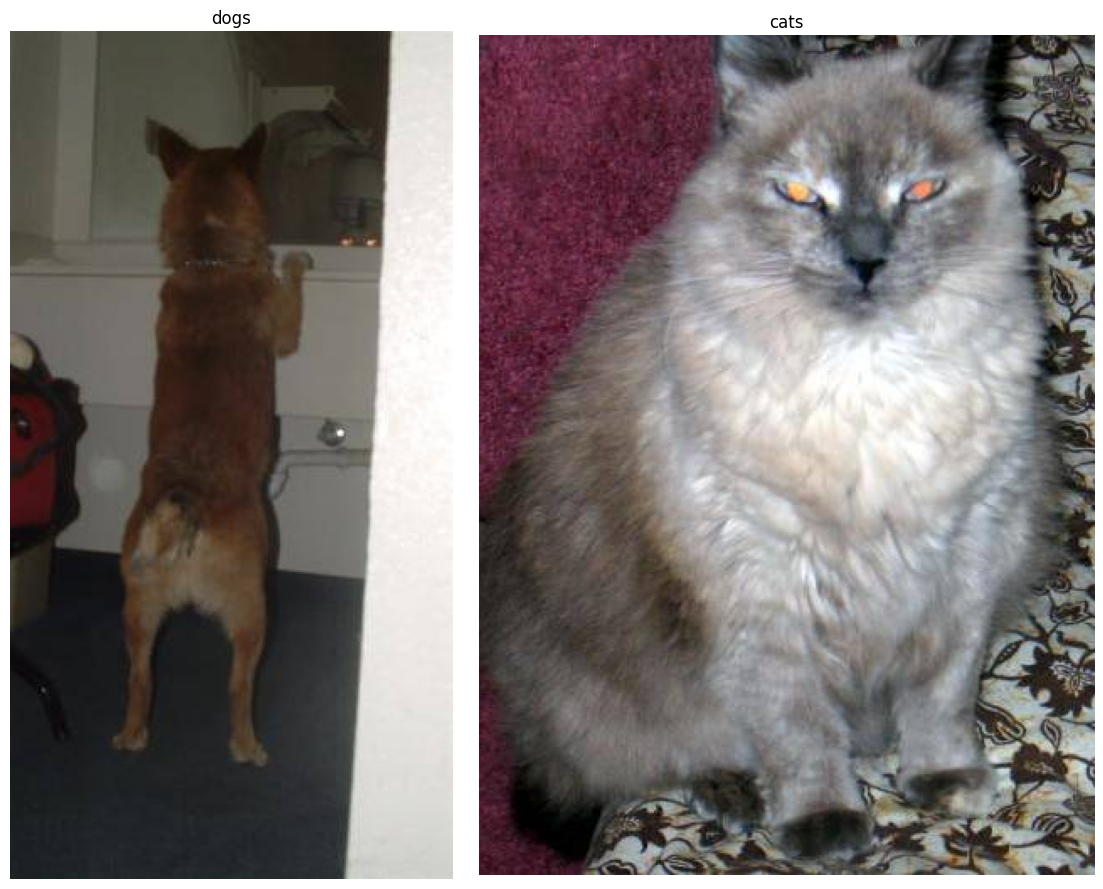

In [11]:
row = 1 
col = 2

plt.figure(figsize=(12, 9))

for i in range(num_classes):
    image = df_singles['Filepath'][i]

    plt.subplot(row, col, i+1)

    plt.imshow(plt.imread(image))

    plt.title(f'{df_singles["Label"][i]}')

    plt.axis('off')

    plt.tight_layout()

plt.show()

# Separação treino e teste

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, stratify=labels, random_state=42)

In [13]:
# Estrutura dos dados está multidimensional: 10000 elementos, 64 linhas, 64 colunas, 3 camadas (RGB)
# É necessário fazer reshape para ter dado unidimensional
print(X_test.shape)
print(X_train.shape)

(5000, 64, 64, 3)
(15000, 64, 64, 3)


# Reshape

In [14]:
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])

In [15]:
X_train_flat.shape

(15000, 12288)

# Label Encoder

Conversão de strings para classes binárias

In [16]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Converte vetor de classes (inteiro) em matriz de classe categórica
y_train_tf = keras.utils.to_categorical(y_train, num_classes)
y_test_tf = keras.utils.to_categorical(y_test, num_classes)

In [17]:
y_test_tf

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Criação do modelo

## Checkpointer

ModelCheckpoint utilizado para salvar uma cópia do modelo

In [18]:
from distutils.file_util import copy_file

checkpointer = ModelCheckpoint(filepath='weights.best.hdf5', verbose=0, save_best_only=True)

## Definindo Input Shape e Learning Rate

In [19]:
# Shape das imagens
input_shape = (image_size, image_size, 3)

# Learning rate
learning_rate = 0.001

## Definindo Seed, modelo e adicionando camadas

In [20]:
tf.random.set_seed(44)

# Declarando modelo
model = Sequential()

# 1 camada convolucional de 128 neuronios + filtro matriz 3x3 + movimentação stride 2x2 + padding ativo (sem bordas de zeros) + função ativação ReLU + regularização L2 ativada
model.add(Conv2D(
    128,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding='same',
    activation='relu',
    kernel_regularizer=keras.regularizers.l2(0.001),
    input_shape=input_shape
))

# Camada MaxPolling ativada, matriz 2x2. Padding ativo
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=None,
    padding='same'
))

# Regularização de dropout ativa
model.add(Dropout(
    0.5
))

# 2 camada convolucional de 92 neuronios + filtro matriz 3x3 + movimentação stride 2x2 + padding ativo (sem bordas de zeros) + função ativação ReLU + regularização L2 ativada
model.add(Conv2D(
    92,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding='same',
    activation='relu',
    kernel_regularizer=keras.regularizers.l2(0.001)
))

# Camada MaxPolling ativada, matriz 2x2. Padding ativo
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=None,
    padding='same'
))

# Regularização de dropout ativa
model.add(Dropout(
    0.5
))

# Camada para flat dos dados
model.add(Flatten())

# Camada Dense + função ativação ReLU
model.add(Dense(256, activation='relu'))

# Camada de saída da rede, utilizando ativação softmax para criar a probabilidade de pertencimento a uma classe
model.add(Dense(y_train_tf.shape[1], activation='softmax'))


## Configurando Early Stopping e otimizador Adam

Early Stopping é uma técnica para evitar overfiting e economizar tempo de treinamento. Já o otimizador Adam ajusta os pesos de uma rede neural durante o treinamento e acelera o processo.

In [21]:
# Early stopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=10, verbose=1, mode='auto')

# Compilando modelo e aplicando Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate), metrics=['accuracy'])

# Salve os dados do modelo em um arquivo h5
model.save('./cat_dog.h5')
# Resumo do modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 128)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 92)          106076    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 92)          0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 92)          0

c:\Users\Jackson Simionato\.conda\envs\pyspark_env\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Treinando modelo

In [22]:
history = model.fit(X_train, y_train_tf, validation_split=0.25, callbacks=[monitor, checkpointer],
                    verbose=1, epochs=45, batch_size=50, shuffle=True)

Epoch 1/45

225/225 [==============================] - 16s 63ms/step - loss: 0.7332 - accuracy: 0.5473 - val_loss: 0.6811 - val_accuracy: 0.5989
Epoch 2/45
225/225 [==============================] - 13s 59ms/step - loss: 0.6544 - accuracy: 0.6484 - val_loss: 0.6307 - val_accuracy: 0.6760
Epoch 3/45
225/225 [==============================] - 13s 56ms/step - loss: 0.6110 - accuracy: 0.6924 - val_loss: 0.6206 - val_accuracy: 0.6723
Epoch 4/45
225/225 [==============================] - 15s 68ms/step - loss: 0.5951 - accuracy: 0.7014 - val_loss: 0.5712 - val_accuracy: 0.7192
Epoch 5/45
225/225 [==============================] - 13s 57ms/step - loss: 0.5788 - accuracy: 0.7146 - val_loss: 0.5715 - val_accuracy: 0.7208
Epoch 6/45
225/225 [==============================] - 12s 54ms/step - loss: 0.5747 - accuracy: 0.7153 - val_loss: 0.5526 - val_accuracy: 0.7360
Epoch 7/45
225/225 [==============================] - 13s 58ms/step - loss: 0.5572 - accuracy: 0.7298 - val_loss: 0.5797 - val_accuracy

# Validação do modelo

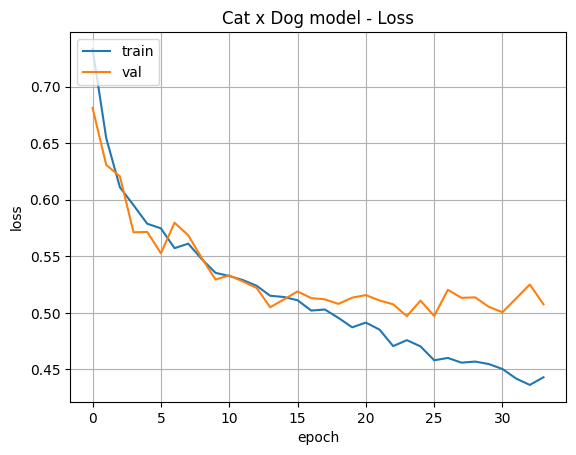

In [23]:
# Plot erro por época
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Cat x Dog model - Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.grid(True)
plt.show()

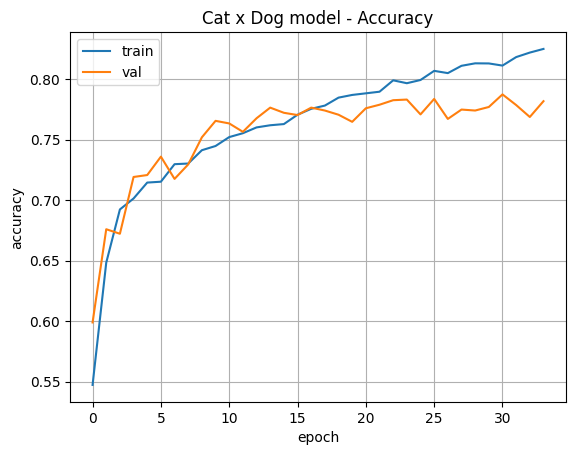

In [24]:
# Plot acurácia por época
# Plot erro por época
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Cat x Dog model - Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.grid(True)
plt.show()

In [25]:
# Armanezar predições modelo
cnn_pred_cat_dog = model.predict(X_test)

157/157 [==============================] - 1s 7ms/step


In [26]:

# Define o índice do valor máximo do modelo de previsão para uma variável
# O valor máximo indica o caractere de previsão do modelo que a imagem representa
cnn_pred_cat_dog = np.argmax(cnn_pred_cat_dog,axis=1)

# Define uma variável para armazenar o rótulo que representa o resultado verdadeiro
y_true = np.argmax(y_test_tf,axis=1)

In [27]:
# Lista de classes em ordem alfabética
animal_labels = sorted(list(set(labels)))

In [29]:
## Matriz de confusão

cnn_cm_cat_dog = metrics.confusion_matrix(y_true, cnn_pred_cat_dog)

# Acurácia
cnn_accuracy_cat_dog = metrics.accuracy_score(y_true, cnn_pred_cat_dog)

# Classification report
print(metrics.classification_report(y_true, cnn_pred_cat_dog, target_names=animal_labels))
print(f"Acurácia: {cnn_accuracy_cat_dog}")

              precision    recall  f1-score   support

        cats       0.79      0.77      0.78      2500
        dogs       0.78      0.79      0.78      2500

    accuracy                           0.78      5000
   macro avg       0.78      0.78      0.78      5000
weighted avg       0.78      0.78      0.78      5000

Acurácia: 0.782


# Função para predição de imagens

In [43]:
#Função para adivinhar o animal
def guess_animal(filepath):
    # Converte o caminho do arquivo para uma imagem
    image = cv2.imread(filepath)
    # Redimensione a imagem e normalize o intervalo de pixels para ficar entre 0 e 1
    img = cv2.resize(image, (image_size, image_size)).astype('float32') / 255.0
    # Expandir a forma do array de imagens
    img = np.expand_dims(img, axis=0)
    # Usando o modelo para prever o animal que representa a imagem
    pred = model.predict(img)
    # Definindo uma variável para armazenar o índice que representa o caractere que representa a imagem
    classes=np.argmax(pred,axis=1)
    # Print no nome do animal previsto
    print(animal_labels[classes[0]])
    # Plote a imagem do animal
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # Desliga o eixo de plotagem
    plt.axis('off')

    plt.show()

In [44]:
# Caminho da pasta de imagens teste
path_imagens_teste = '../../data/imagens_caes_gatos/img_teste/'
path_imagens_teste = Path(path_imagens_teste)
path_imagens_teste

# Arquivos imagens teste
file_paths_teste = list(path_imagens_teste.glob(r'*.jpg'))
file_paths_teste

[WindowsPath('../../data/imagens_caes_gatos/img_teste/cat.475.jpg'),
 WindowsPath('../../data/imagens_caes_gatos/img_teste/cat_202.jpg'),
 WindowsPath('../../data/imagens_caes_gatos/img_teste/dog.238.jpg'),
 WindowsPath('../../data/imagens_caes_gatos/img_teste/dog.30.jpg'),
 WindowsPath('../../data/imagens_caes_gatos/img_teste/dog.jpg')]

1/1 [==============================] - 0s 23ms/step
cats


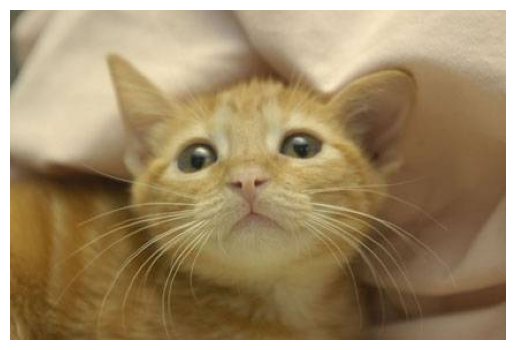

1/1 [==============================] - 0s 26ms/step
cats


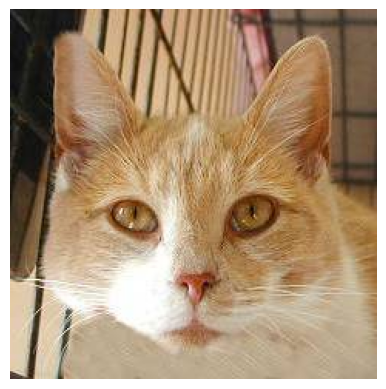

1/1 [==============================] - 0s 27ms/step
dogs


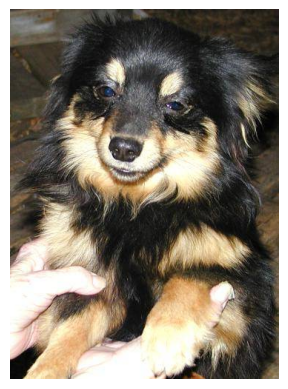

1/1 [==============================] - 0s 39ms/step
dogs


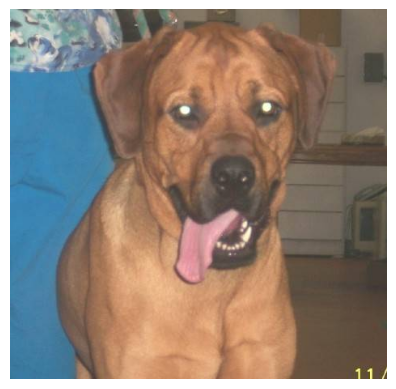

1/1 [==============================] - 0s 17ms/step
dogs


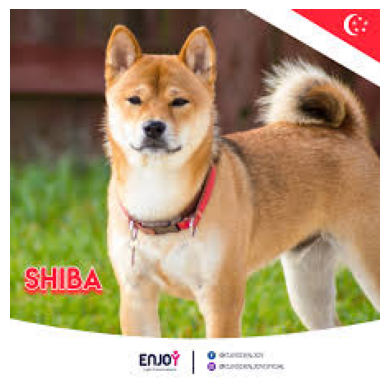

In [45]:
for img_teste in file_paths_teste:
    guess_animal(str(img_teste))